In [3]:
import pandas as pd
import os
import glob
import geopy.distance
import matplotlib.pyplot as plt
import requests
import math
import numpy as np
import seaborn as sns

#Lectura de los Datos

In [4]:
def read_data(folder): 
  '''
  # Pasamos el path del folder donde están los datos dinámicos
  '''
  merged_data = pd.DataFrame() 
  csv_files = glob.glob(os.path.join(folder, "*.csv"))

  for f in csv_files:  
      df = pd.read_csv(f)
      merged_data = pd.concat([merged_data,df])
  return merged_data

def segment_data(data, path_ice, path_ev):
  '''
  Pasamos los datos dinámicos (ya leídos) y los paths a los csv estáticos
  
  '''
  ice_hev = pd.read_csv(path_ice, sep = ';') 
  phev_ev = pd.read_csv(path_ev, sep = ';')
  hev_id = ice_hev.loc[ice_hev['Vehicle Type']=='HEV']
  ice_id = ice_hev.loc[ice_hev['Vehicle Type']=='ICE']
  ev_id = phev_ev.loc[phev_ev['EngineType']=='EV']
  phev_id = phev_ev.loc[phev_ev['EngineType']=='PHEV']
  ev = pd.merge(data,ev_id,on ='VehId', how = 'inner')
  phev = pd.merge(data,phev_id,on ='VehId', how = 'inner')
  hev = pd.merge(data,hev_id,on ='VehId', how = 'inner')
  ice = pd.merge(data,ice_id,on ='VehId', how = 'inner')
  return ev, phev, hev, ice

data = read_data('/content/drive/MyDrive/Monitoría EV/Data')
path_ice, path_ev ='/content/drive/MyDrive/Monitoría EV/Static Data/VED_Static_Data_ICE&HEV.csv','/content/drive/MyDrive/Monitoría EV/Static Data/VED_Static_Data_PHEV&EV.csv'
ev, phev, hev, ice = segment_data(data,path_ice,path_ev)


#Exploratory Data Analysis datos crudos

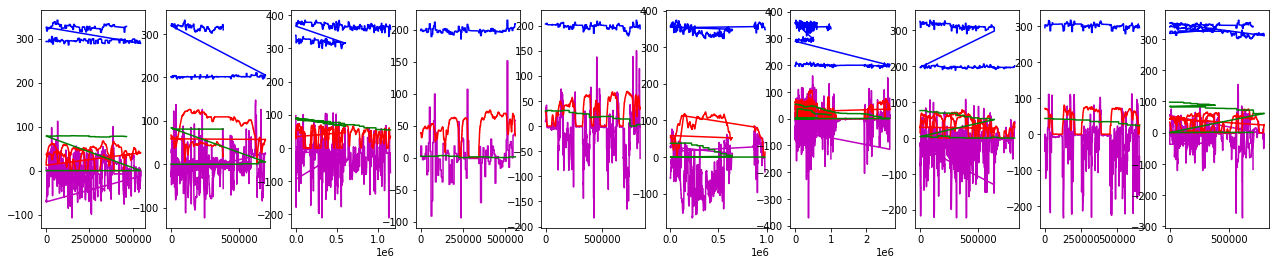

In [5]:
fig, ax = plt.subplots(1, 10, figsize=(22,4))
trips = np.unique(phev['Trip'].values)
for i in range(10):
  trip = phev[phev['Trip'] == 1560+i]
  if len(trip) == 0:
    trip = phev[phev['Trip'] == trips[i]]
  time = trip['Timestamp(ms)'].values
  curr = trip['HV Battery Current[A]'].values
  volt = trip['HV Battery Voltage[V]'].values
  speed = trip['Vehicle Speed[km/h]'].values
  soc = trip['HV Battery SOC[%]'].values
  ax[i].plot(time,curr, 'm')
  ax[i].plot(time,volt, 'b')
  ax[i].plot(time,speed, 'r')
  ax[i].plot(time,soc, 'g')

Graficamos los trips aleatoriamente y constatamos que hay errores en las gráficas 2 y 8. Esto indica que hay 2 trips dentro de 1. Este error se arregla con el método "createidx" más abajo.

Limpiar datos carros eléctricos

In [6]:
phev.drop(columns = ['MAF[g/sec]','Engine RPM[RPM]','Absolute Load[%]','Short Term Fuel Trim Bank 1[%]','Short Term Fuel Trim Bank 2[%]', 
                   'Long Term Fuel Trim Bank 1[%]', 'Long Term Fuel Trim Bank 2[%]','Fuel Rate[L/hr]', 'Air Conditioning Power[kW]', 'Transmission',
                   'EngineType', 'Drive Wheels', 'Engine Configuration & Displacement', 'Vehicle Class'], inplace = True)
phev.fillna(method='ffill', inplace = True)

In [7]:
#Para ahorrar RAM
del ev
del hev
del ice

In [8]:
def create_idx(data): 
  '''
  Agrupamos por cambio de trip y timestamps = 0
  '''
  i = 0
  j = 0
  indx = []
  idx = 0
  prevtrip = data['Trip'][0]
  for trip, time in zip(data['Trip'],data['Timestamp(ms)']):
    if prevtrip!=trip or time == 0:
      idx += 1
      pendiente = False
    indx.append(idx)
    prevtrip = trip
  return indx

indices = create_idx(phev)
phev.insert(len(phev.columns),'Indx',indices)

#Exploratory Data Analysis con índice

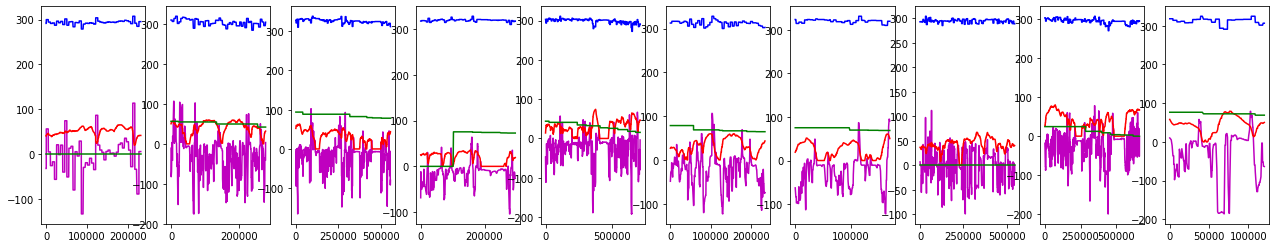

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(22,4))
for i in range(1,11):
  trip = phev[phev['Indx'] == i]
  time = trip['Timestamp(ms)'].values
  curr = trip['HV Battery Current[A]'].values
  volt = trip['HV Battery Voltage[V]'].values
  speed = trip['Vehicle Speed[km/h]'].values
  soc = trip['HV Battery SOC[%]'].values
  ax[i-1].plot(time,curr, 'm')
  ax[i-1].plot(time,volt, 'b')
  ax[i-1].plot(time,speed, 'r')
  ax[i-1].plot(time,soc, 'g')

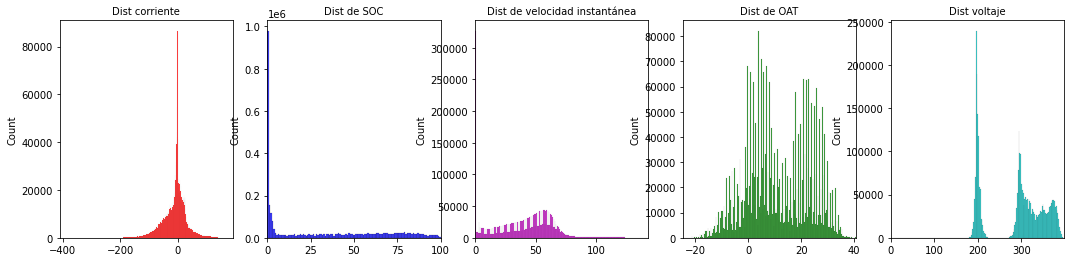

In [10]:
def Distribution_plot(df):
    amount_val = df['HV Battery Current[A]'].values
    time_val = df['HV Battery SOC[%]'].values
    v1_val = df['Vehicle Speed[km/h]'].values
    v2_val = df['OAT[DegC]'].values
    v3_val = df['HV Battery Voltage[V]'].values

    fig, ax = plt.subplots(1, 5, figsize=(18,4))

    sns.histplot(amount_val, ax=ax[0], color='r')
    ax[0].set_title('Dist corriente', fontsize=10)
    ax[0].set_xlim([min(amount_val), max(amount_val)])

    sns.histplot(time_val, ax=ax[1], color='b')
    ax[1].set_title('Dist de SOC', fontsize=10)
    ax[1].set_xlim([min(time_val), max(time_val)])

    sns.histplot(v1_val, ax=ax[2], color='m')
    ax[2].set_title('Dist de velocidad instantánea', fontsize=10)
    ax[2].set_xlim([min(v1_val), max(v1_val)])

    sns.histplot(v2_val, ax=ax[3], color='g')
    ax[3].set_title('Dist de OAT', fontsize=10)
    ax[3].set_xlim([min(v2_val), max(v2_val)])

    sns.histplot(v3_val, ax=ax[4], color='c')
    ax[4].set_title('Dist voltaje', fontsize=10)
    ax[4].set_xlim([min(v3_val), max(v3_val)])

    plt.show()

Distribution_plot(phev)

#Agrupamos datos por trips 

Creamos variable de potencia instántanea

In [11]:
def suma_riemann(data):
  potencia = []
  previdx = data['Trip'][0]
  prevtime = data['Timestamp(ms)'][0]
  pot = 0
  for time,curr,volt,idx in zip(data['Timestamp(ms)'][1:],data['HV Battery Current[A]'][1:],data['HV Battery Voltage[V]'][1:],data['Indx'][1:]):
    if previdx != idx:
      potencia.append(pot)
      pot = 0
    else:
      pot += -(time-prevtime)*curr*volt/3600000
    previdx = idx
    prevtime = time
  potencia.append(pot) 
  return pd.DataFrame(potencia, columns = ['Consumo'])

potencia = suma_riemann(phev)

Creamos variable de aceleración

In [12]:
def acceleration(data):
  acel = []
  previdx = data['Trip'][0]
  prevtime = data['Timestamp(ms)'][0]
  prevspeed = data['Vehicle Speed[km/h]'][0]
  temp = []
  for time,speed,idx in zip(data['Timestamp(ms)'][1:],data['Vehicle Speed[km/h]'][1:],data['Indx'][1:]):
    if previdx != idx:
      if temp:
        acel.append(np.mean(temp))
      else:
        acel.append(0)
      temp = []
    else:
      if time != prevtime:
        temp.append((speed-prevspeed)/(time-prevtime))
    previdx = idx
    prevspeed = speed
    prevtime = time
  acel.append(np.mean(temp)) 
  return pd.DataFrame(acel, columns = ['Mean accel'])

acel = acceleration(phev)

Creamos otras variables con la función groupby de Python

In [14]:
phev['Potencia instantanea'] = phev.apply(lambda x: -x['HV Battery Current[A]']*x['HV Battery Voltage[V]'], axis = 1)

In [15]:
means = phev.groupby(phev['Indx']).mean().loc[:,['OAT[DegC]','Vehicle Speed[km/h]','Potencia instantanea']]
vars = phev.groupby(phev['Indx']).var().loc[:,['Vehicle Speed[km/h]']]
firsts = phev.groupby(phev['Indx']).first().loc[:,['Latitude[deg]','Longitude[deg]', 'HV Battery SOC[%]']]
lasts = phev.groupby(phev['Indx']).last().loc[:,['Latitude[deg]','Longitude[deg]', 'HV Battery SOC[%]']]
max = phev.groupby(phev['Indx']).max().loc[:,['Timestamp(ms)']]
vars.columns = ['Variance speed']
max.columns = ['Tiempo']
means.columns = ['Mean OAT', 'Mean speed', 'Consumo']
firsts.columns = ['First lat', 'First lon', 'First SOC']
lasts.columns = ['Last lat', 'Last lon', 'Last SOC']
means.drop(columns = ['Consumo'], inplace = True) #Comentar esta línea si se desea calcular el consumo por promedio
new_df = pd.concat([acel,means,potencia,vars,firsts,lasts,max],axis=1)

In [ ]:
#new_df['Consumo Total'] = new_df.apply(lambda x: x['Consumo']*x['Tiempo']/3600000, axis = 1)

In [16]:
new_df.dropna(inplace = True)
new_df.reset_index(inplace= True)

In [17]:
new_df

,index,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,First lat,First lon,First SOC,Last lat,Last lon,Last SOC,Tiempo
0,1,0.000083,5.604167,51.039873,10.586054,81.842180,42.300565,-83.735444,0.000000,42.317942,-83.717294,0.000000,231500.0
1,2,0.000166,6.270581,40.940144,746.655749,275.093236,42.284652,-83.743512,56.432915,42.294944,-83.719558,42.081017,276700.0
2,3,0.000006,9.057898,31.962958,772.654242,314.025921,42.315965,-83.733724,93.848106,42.278339,-83.746410,78.275955,555100.0
3,4,-0.000016,13.771208,19.715244,400.821651,145.546980,42.295755,-83.705118,0.000000,42.290281,-83.712879,72.670891,296200.0
4,5,0.000009,5.270513,30.416974,1579.822984,292.818778,42.290356,-83.712937,43.936710,42.318152,-83.716965,15.483547,712200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,3601,-0.000488,25.290773,33.660028,-47.758678,449.852321,42.284792,-83.801773,0.000000,42.278729,-83.739480,0.392157,896700.0
3601,3602,0.000329,27.528889,49.327569,1411.949190,766.581576,42.270603,-83.741008,76.470612,42.284530,-83.801027,68.627472,457200.0
3602,3603,-0.000020,15.792056,59.226438,4331.242964,1972.311523,42.284845,-83.743428,45.098053,42.283279,-83.740950,0.784314,4633200.0
3603,3604,0.000267,14.992613,24.523559,1384.208198,686.590728,42.277984,-83.748662,28.235304,42.285226,-83.800879,15.686279,1444500.0


Creamos variable de distancia

In [18]:
def dists(data):
  dists = []
  for prevlat,prevlon,lat,lon in zip(data['First lat'],data['First lon'],data['Last lat'], data['Last lon']):
    dists.append(geopy.distance.geodesic((prevlat,prevlon),(lat,lon)).m)
  return pd.DataFrame(dists, columns = ['Distance'])
distancia = dists(new_df)
new_df = pd.concat([new_df,distancia],axis=1)

Calculamos la elevación

In [19]:
from re import T
def funcion(df1, API_endpoint, inicio, fin, first):
    data=[]
    for i in range(inicio,fin):
        if first:
          data.append([df1['First lat'][i],df1['First lon'][i]])
        else:
          data.append([df1['Last lat'][i],df1['Last lon'][i]])
    x = 0
    while x != 200:
        r = requests.post(url = API_endpoint, json= data)
        x = r.status_code
    str = r.content.decode("utf-8")
    str = str.replace('[','')
    str = str.replace(']','')
    lista = list(np.float_(str.split(',')))
    for i in range (inicio,fin):
        if first:
          df1['elevation_2'][i]=lista[i-inicio]
        else:
          df1['elevation_3'][i]=lista[i-inicio]
    return(df1)

API_ENDPOINT = "https://elevation.racemap.com/api"
new_df.insert(len(new_df.columns),'elevation_2',[np.nan]*len(new_df))
new_df.insert(len(new_df.columns),'elevation_3',[np.nan]*len(new_df))
new_df = funcion(new_df,API_ENDPOINT,0,len(new_df), True)
new_df = funcion(new_df,API_ENDPOINT,0,len(new_df), False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
new_df['Delta SOC'] = new_df.apply(lambda x: x['First SOC'] - x['Last SOC'], axis=1)

Creamos variable de pendiente

In [21]:
def slope(data):
  slope = []
  for prevelev,elev,dist in zip(data['elevation_2'],data['elevation_3'],data['Distance']):
    try:
      slope.append(math.degrees(math.asin((elev-prevelev)/dist)))
    except:
      slope.append(90)
    prevelev = elev
  return pd.DataFrame(slope, columns = ['Slope'])
pendiente = slope(new_df)
new_df = pd.concat([new_df,pendiente],axis = 1)

Limpiar datos

In [22]:
new_df.drop(columns=['elevation_2','elevation_3','First SOC','Last SOC', 'First lon', 'First lat', 'Last lon', 'Last lat', 'index'],inplace=True)

In [23]:
new_df

,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,Tiempo,Distance,Delta SOC,Slope
0,0.000083,5.604167,51.039873,10.586054,81.842180,231500.0,2442.402125,0.000000,0.743002
1,0.000166,6.270581,40.940144,746.655749,275.093236,276700.0,2282.587997,14.351898,0.625280
2,0.000006,9.057898,31.962958,772.654242,314.025921,555100.0,4308.383157,15.572151,-0.349338
3,-0.000016,13.771208,19.715244,400.821651,145.546980,296200.0,882.822998,-72.670891,-0.011681
4,0.000009,5.270513,30.416974,1579.822984,292.818778,712200.0,3105.377307,28.453163,0.610794
...,...,...,...,...,...,...,...,...,...
3600,-0.000488,25.290773,33.660028,-47.758678,449.852321,896700.0,5182.092440,-0.392157,-0.168015
3601,0.000329,27.528889,49.327569,1411.949190,766.581576,457200.0,5186.998996,7.843140,0.322033
3602,-0.000020,15.792056,59.226438,4331.242964,1972.311523,4633200.0,268.438729,44.313739,1.881585
3603,0.000267,14.992613,24.523559,1384.208198,686.590728,1444500.0,4381.597083,12.549025,0.353067


#Exploratory Data Analysis con datos agrupados


In [24]:
new_df.drop(columns =['Delta SOC'],inplace=True)
new_df.corr()

,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,Tiempo,Distance,Slope
Mean accel,1.000000,-0.041863,-0.049280,-0.110652,0.064015,0.087933,0.040451,-0.016411
Mean OAT,-0.041863,1.000000,0.032158,-0.023999,0.111398,-0.021423,0.009486,-0.024820
Mean speed,-0.049280,0.032158,1.000000,0.063001,0.275344,-0.238937,0.253439,0.051103
Consumo,-0.110652,-0.023999,0.063001,1.000000,0.245523,0.290309,0.266303,0.049279
Variance speed,0.064015,0.111398,0.275344,0.245523,1.000000,0.208219,0.329607,-0.031140
Tiempo,0.087933,-0.021423,-0.238937,0.290309,0.208219,1.000000,0.160705,-0.065274
Distance,0.040451,0.009486,0.253439,0.266303,0.329607,0.160705,1.000000,0.053438
Slope,-0.016411,-0.024820,0.051103,0.049279,-0.031140,-0.065274,0.053438,1.000000


In [25]:
new_df.corr(method = 'spearman')

,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,Tiempo,Distance,Slope
Mean accel,1.000000,-0.046852,-0.063176,-0.241055,0.081282,0.136266,0.045966,-0.025653
Mean OAT,-0.046852,1.000000,0.030152,-0.008330,0.116650,-0.009554,0.012238,-0.005184
Mean speed,-0.063176,0.030152,1.000000,0.013076,0.049828,-0.344217,0.178231,0.079317
Consumo,-0.241055,-0.008330,0.013076,1.000000,0.214003,0.293180,0.304853,0.117535
Variance speed,0.081282,0.116650,0.049828,0.214003,1.000000,0.363444,0.320113,-0.056703
Tiempo,0.136266,-0.009554,-0.344217,0.293180,0.363444,1.000000,0.512016,-0.041215
Distance,0.045966,0.012238,0.178231,0.304853,0.320113,0.512016,1.000000,0.031309
Slope,-0.025653,-0.005184,0.079317,0.117535,-0.056703,-0.041215,0.031309,1.000000


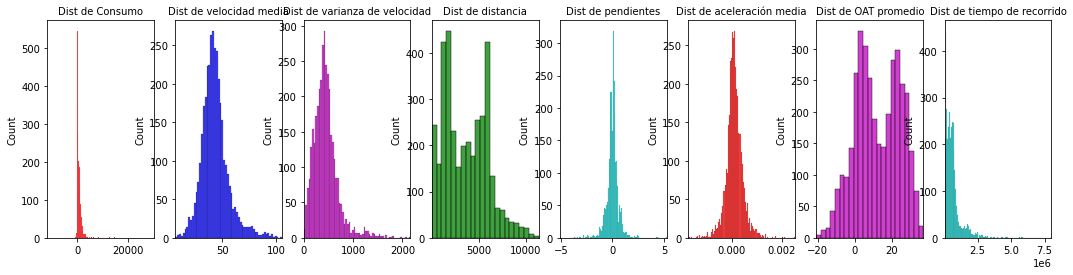

In [28]:
del max
def Distribution_plot(df):
    amount_val = df['Consumo'].values
    time_val = df['Mean speed'].values
    v1_val = df['Variance speed'].values
    v2_val = df['Distance'].values
    v3_val = df['Slope'].values
    v4_val = df['Mean accel'].values
    v5_val = df['Mean OAT'].values
    v6_val = df['Tiempo'].values

    fig, ax = plt.subplots(1, 8, figsize=(18,4))

    sns.histplot(amount_val, ax=ax[0], color='r')
    ax[0].set_title('Dist de Consumo', fontsize=10)
    ax[0].set_xlim([min(amount_val), max(amount_val)])

    sns.histplot(time_val, ax=ax[1], color='b')
    ax[1].set_title('Dist de velocidad media', fontsize=10)
    ax[1].set_xlim([min(time_val), max(time_val)])

    sns.histplot(v1_val, ax=ax[2], color='m')
    ax[2].set_title('Dist de varianza de velocidad', fontsize=10)
    ax[2].set_xlim([min(v1_val), max(v1_val)])

    sns.histplot(v2_val, ax=ax[3], color='g')
    ax[3].set_title('Dist de distancia', fontsize=10)
    ax[3].set_xlim([min(v2_val), max(v2_val)])

    sns.histplot(v3_val, ax=ax[4], color='c')
    ax[4].set_title('Dist de pendientes', fontsize=10)
    ax[4].set_xlim([min(v3_val), max(v3_val)])

    sns.histplot(v4_val, ax=ax[5], color='r')
    ax[5].set_title('Dist de aceleración media', fontsize=10)
    ax[5].set_xlim([min(v4_val), max(v4_val)])

    sns.histplot(v5_val, ax=ax[6], color='m')
    ax[6].set_title('Dist de OAT promedio', fontsize=10)
    ax[6].set_xlim([min(v5_val), max(v5_val)])

    sns.histplot(v6_val, ax=ax[7], color='c')
    ax[7].set_title('Dist de tiempo de recorrido', fontsize=10)
    ax[7].set_xlim([min(v6_val), max(v6_val)])

    plt.show()

Distribution_plot(new_df)

#Entrenamiento de modelos

Linear Regression Score:  -0.9213213108203082 3.2314983611386174
Tree Regression Score:  -1.845909425844468 3.348576313722394
Lasso Regression Score:  -1.0525009383914465 3.53967019339462
GBR Score:  -0.385077947656157 1.9035729569519175


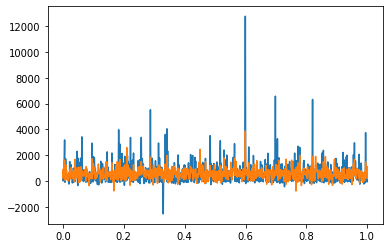

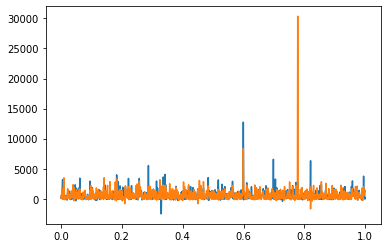

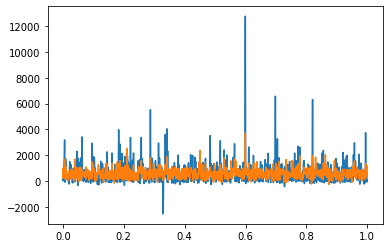

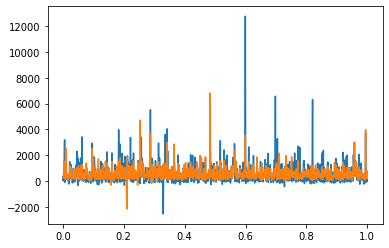

In [29]:
'''
Modelo base
'''
from sklearn.linear_model import LinearRegression, QuantileRegressor, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

new_df = new_df.dropna()
y = new_df['Consumo']
X = new_df.drop(columns=['Consumo'])
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print('Linear Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

regressor = DecisionTreeRegressor(random_state=0)
model = regressor.fit(X_train,y_train)
scores = cross_val_score(regressor, X, y, cv=10)
print('Tree Regression Score: ' , np.mean(scores), scores.std())
predicted = model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

reg = Lasso().fit(X_train, y_train)
scores = cross_val_score(Lasso(), X, y, cv=10)
print('Lasso Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
model = reg.fit(X_train, y_train)
scores = cross_val_score(reg, X, y, cv=10)
print('GBR Score: ' , np.mean(scores), scores.std())
predicted =  model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
[(variance_inflation_factor(X.values, i),X.columns[i])
                          for i in range(len(X.columns))]
#Hay un VIF alto para Mean speed

[(1.1211569043741272, 'Mean accel'),
 (1.9924669641218118, 'Mean OAT'),
 (5.920845622578882, 'Mean speed'),
 (5.3135578143856845, 'Variance speed'),
 (2.086198079139498, 'Tiempo'),
 (4.078432776496534, 'Distance'),
 (1.0115112822684338, 'Slope')]

Linear Regression Score:  -0.8396183045445509 3.001958671442214
Tree Regression Score:  -1.9589267612489045 4.131249500639199
Lasso Regression Score:  -0.9618873141642279 3.284592815650317
GBR Score:  -0.384267893801593 1.808904590967165


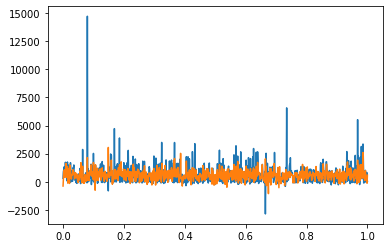

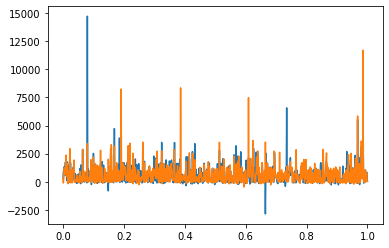

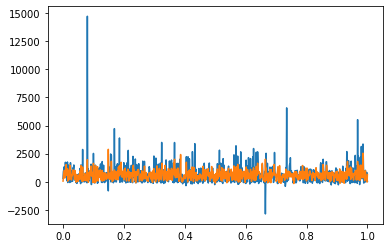

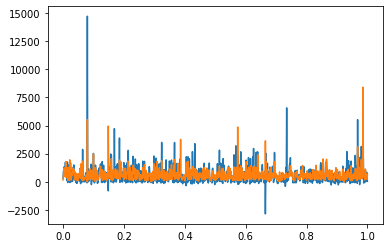

In [31]:
'''
Modelo sin Mean spead
'''
from sklearn.linear_model import LinearRegression, QuantileRegressor, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

new_df = new_df.dropna()
y = new_df['Consumo']
X = new_df.drop(columns=['Consumo', 'Mean speed'])
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print('Linear Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

regressor = DecisionTreeRegressor(random_state=0)
model = regressor.fit(X_train,y_train)
scores = cross_val_score(regressor, X, y, cv=10)
print('Tree Regression Score: ' , np.mean(scores), scores.std())
predicted = model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

reg = Lasso().fit(X_train, y_train)
scores = cross_val_score(Lasso(), X, y, cv=10)
print('Lasso Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
model = reg.fit(X_train, y_train)
scores = cross_val_score(reg, X, y, cv=10)
print('GBR Score: ' , np.mean(scores), scores.std())
predicted =  model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

#Modelos sin outliers

In [32]:
from scipy.spatial.distance import mahalanobis
import scipy as sp
def cut_outliers(data):
  Sx = data.cov().values
  invcov = sp.linalg.inv(Sx)
  mean = data.mean().values
  x_minus_mu = data-mean
  left_term = np.dot(x_minus_mu,invcov)
  mahal_nueva = np.dot(left_term,x_minus_mu.T)
  dist = np.diag(mahal_nueva)
  p = np.percentile(dist,90)
  data.insert(len(data.columns), 'Mahal', dist)
  data = data[data['Mahal']<p]
  new_data = data.drop(columns = ['Mahal'], axis=1)
  return new_data
no_outliers = cut_outliers(new_df)
new_df.drop(columns = ['Mahal'], inplace = True)

Linear Regression Score:  -0.006329933678928057 0.863448691876625
Tree Regression Score:  -0.42395717454616494 0.6717978199741231
Lasso Regression Score:  -0.084289446111671 1.0024135826772305
GBR Score:  0.23277659301034093 0.5089870408273316


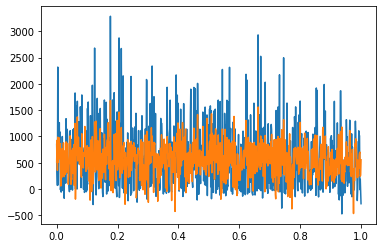

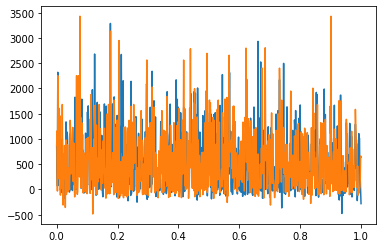

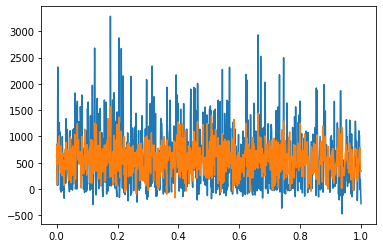

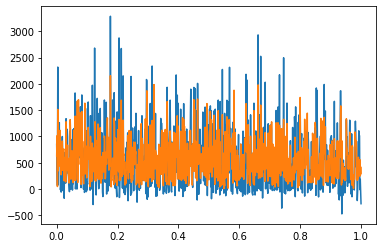

In [33]:
y = no_outliers['Consumo']
X = no_outliers.drop(columns=['Consumo'])
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print('Linear Regression Score: ' , scores.mean(), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

regressor = DecisionTreeRegressor(random_state=0)
model = regressor.fit(X_train,y_train)
scores = cross_val_score(regressor, X, y, cv=10)
print('Tree Regression Score: ' , scores.mean(), scores.std())
predicted = model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

reg = Lasso().fit(X_train, y_train)
scores = cross_val_score(Lasso(), X, y, cv=10)
print('Lasso Regression Score: ' , scores.mean(), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

params = {
    "n_estimators": 800,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
model = reg.fit(X_train, y_train)
scores = cross_val_score(reg, X, y, cv=10)
print('GBR Score: ' , scores.mean(), scores.std())
predicted =  model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)